In diesem Skript wird getestet, wie man das Rundensignal am besten finden kann.

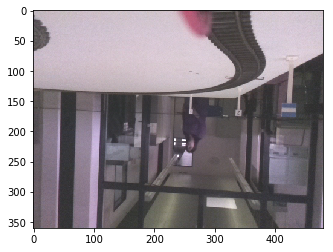

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('images/rundensignale/2019-05-02 09%3A52%3A40.740.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hsv_h,hsv_s,hsv_v = cv2.split(hsv)
plt.imshow(img_rgb)

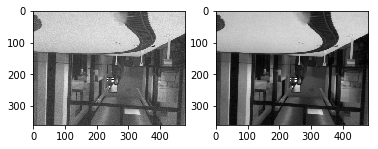

In [2]:
height, width = hsv_v.shape

imgTopHat = np.zeros((height, width, 1), np.uint8)
imgBlackHat = np.zeros((height, width, 1), np.uint8)

structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(hsv_v, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(hsv_v, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(hsv_v, imgTopHat)
imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

imgMaxContrast = imgGrayscalePlusTopHatMinusBlackHat
hsv = np.dstack([hsv_h, hsv_s, imgMaxContrast])
plt.subplot(1,2,1)
plt.imshow(imgMaxContrast, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(hsv_v, cmap='gray')

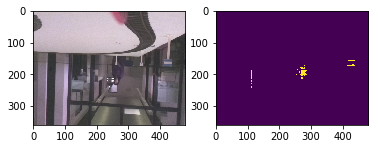

In [3]:
# simple threshold in HSV
blue_lower = np.array([90,60,0],np.uint8)
blue_upper = np.array([140,255,255],np.uint8)

thresh = cv2.inRange(hsv, blue_lower, blue_upper)

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.subplot(1, 2, 2)
plt.imshow(thresh)

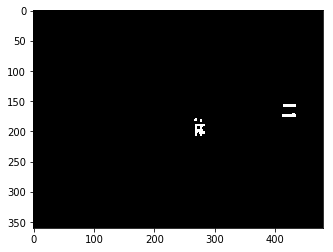

In [4]:
struct = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
image_open = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,struct)
plt.imshow(image_open, cmap='gray')

Area:  21.0
Zenter x:  268
Zenter y: 180
Area:  80.0
Zenter x:  424
Zenter y: 173
Area:  63.0
Zenter x:  424
Zenter y: 157


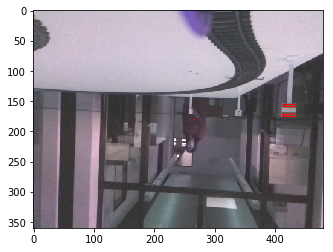

In [5]:
# After finding edges we have to find contours
# Contour is a curve of points with no gaps in the curve
# It will help us to find location of shapes

# cv2.RETR_EXTERNAL is passed to find the outermost contours (because we want to outline the shapes)
# cv2.CHAIN_APPROX_SIMPLE is removing redundant points along a line
(_, cnts, _) = cv2.findContours(image_open, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


'''
We are going to use contour approximation method to find vertices of
geometric shapes. The alogrithm  is also known as Ramer Douglas Peucker alogrithm.
In OpenCV it is implemented in cv2.approxPolyDP method.abs
detectShape() function below takes a contour as parameter and
then returns its shape
 '''


def detectShape(cnt):
    shape = 'unknown'
    # calculate perimeter using
    peri = cv2.arcLength(c, True)
    # apply contour approximation and store the result in vertices
    vertices = cv2.approxPolyDP(c, 0.1 * peri, True)

    # If the shape it triangle, it will have 3 vertices
    if len(vertices) == 3:
        shape = 'triangle'

    # if the shape has 4 vertices, it is either a square or
    # a rectangle
    elif len(vertices) == 4:
        # using the boundingRect method calculate the width and height
        # of enclosing rectange and then calculte aspect ratio

        x, y, width, height = cv2.boundingRect(vertices)
        aspectRatio = float(width) / height

        # a square will have an aspect ratio that is approximately
        # equal to one, otherwise, the shape is a rectangle
        if aspectRatio >= 0.95 and aspectRatio <= 1.05:
            shape = "square"
        else:
            shape = "rectangle"

    # if the shape is a pentagon, it will have 5 vertices
    elif len(vertices) == 5:
        shape = "pentagon"

    # otherwise, we assume the shape is a circle
    else:
        shape = "circle"

    # return the name of the shape
    return shape


# Now we will loop over every contour
# call detectShape() for it and
# write the name of shape in the center of image

# loop over the contours
for c in cnts:
    # compute the moment of contour
    M = cv2.moments(c)
    if(M['m00']!=0.0):
        # From moment we can calculte area, centroid etc
        # The center or centroid can be calculated as follows
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])

        if(M['m00']>20 and M['m00']<100):
            cv2.drawContours(img, [c], -1, (255, 0, 0), 1)
            print('Area: ', M['m00'])
            print('Zenter x: ', cX)
            print('Zenter y:', cY)

        # Write the name of shape on the center of shapes
        #cv2.putText(ausschnitt_big, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # show the output image
        plt.imshow(img)